# Final Project: Electricity Consumption
File: electricity_consumption_data.csv

This dataset contains information on electricity usage.

## 1.0 Preparing Jupyter Notebook

### Package Downloads

In [60]:
#Import necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Jupyter Notebook Settings

In [2]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns',100)

### Function Creation

#### Graphing Functions

In [3]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
#Create a scatterplot graph
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#### Seasonality Functions

In [5]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
#Create a rolling mean of the data to understand the trend

def roll_mean(df_column,window,title,xlabel,ylabel):

    plt.figure(figsize=(10,6))
    rolmean = df_column.rolling(window).mean()

    # Plot the original data and the rolling mean
    plt.figure(figsize=(10, 6))
    plt.plot(df_column, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean (window={window})')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend and display plot
    plt.legend(loc='best')
    plt.show()

In [7]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

#### Least Squares Function

In [8]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.plot(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

def get_least_squares_line(x_value, y_value):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Getting the coefficients of the least squares line
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

In [10]:
def calculate_residuals(x_value, y_value, slope, intercept):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Predicting y values using the provided slope and intercept
    y_pred = slope * x + intercept

    # Calculating residuals
    residuals = y - y_pred

    return residuals

#### ARIMA Modeling Functions

In [11]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [12]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore")

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [13]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

#### Forecast Functions

In [14]:
def test_training_model(train_data, test_data, predictions,
                        x_label, y_label, title,prediction_label):
    # Plot original data
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data, label='Train Data', color='cornflowerblue')
    plt.plot(test_data.index, test_data, label='Test Data', color='mediumseagreen')
    plt.plot(predictions.index, predictions, label=prediction_label, color='darkorange',linestyle='--')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

In [15]:
def model_forecast(original_data, original_data_sales, predictions,
                        x_label, y_label, title, prediction_label):
    # Plot original data
    plt.figure(figsize=(10, 6))
    plt.plot(original_data.index, original_data_sales, label='Original Data', color='cornflowerblue')
    plt.plot(predictions.index, predictions, label=prediction_label, color='mediumseagreen', linestyle='--')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend()

    # Show plot
    plt.show()

## 1.1 Data Preprocessing
Load the dataset and convert the date information into a datetime object to facilitate time series analysis.
Check for missing values and anomalies, and handle them appropriately.

### Import data

In [16]:
#Load in the data from electricity consumption file from data files
electricity_consumption_original = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Applied Statistics & Modeling/Final Project/Data Files/electricity_consumption_data.csv')
electricity_consumption_original

,Date,Electricity_Consumption
0,2020-01-01 00:00:00,134.183010
1,2020-01-01 01:00:00,67.498984
2,2020-01-01 02:00:00,140.533978
3,2020-01-01 03:00:00,27.359333
4,2020-01-01 04:00:00,50.032748
...,...,...
35036,2023-12-30 20:00:00,109.420824
35037,2023-12-30 21:00:00,200.915641
35038,2023-12-30 22:00:00,45.851352
35039,2023-12-30 23:00:00,35.032760


The data has two columns 'Date' and 'Electricity_Consumption'. The date column is in a datetime format and is taken on hourly recordings. Electricity consumption is the value at that hour of time.

In [17]:
#Create a copy of the orignal dataframe so that it can be modified
electricity_consumption=electricity_consumption_original.copy()

### Preprocess dataframe

In [18]:
#Make sure that date is in datetime format
#Set the index to be the date column
electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'])
electricity_consumption.set_index('Date',inplace=True)
electricity_consumption

,Electricity_Consumption
Date,
2020-01-01 00:00:00,134.183010
2020-01-01 01:00:00,67.498984
2020-01-01 02:00:00,140.533978
2020-01-01 03:00:00,27.359333
2020-01-01 04:00:00,50.032748
...,...
2023-12-30 20:00:00,109.420824
2023-12-30 21:00:00,200.915641
2023-12-30 22:00:00,45.851352


In [19]:
#Double check the columns are in the right format
#Expect '<M8[ns]' for index
#Expect 'float64' or 'int64' for Electricity_Consumption
print('Date dtype: ',electricity_consumption.index.dtype)
print('')
print('Monthly Mean dtype: ',electricity_consumption['Electricity_Consumption'].dtype)

Date dtype:  datetime64[ns]

Monthly Mean dtype:  float64


### Check for Missing Values

In [20]:
#Use isna is to create a series of true and false
#sum those to get a total number of missing values
#if it is 0 you can continue
electricity_consumption['Electricity_Consumption'].isna().sum()

0

### Check for Anomalies

In [21]:
#Create zscore value
electricity_consumption['zscore'] = (electricity_consumption['Electricity_Consumption'] - electricity_consumption['Electricity_Consumption'].mean()) / electricity_consumption['Electricity_Consumption'].std()

#Identify anomalies where their standard deviation is greater than 3
anomalies = electricity_consumption[abs(electricity_consumption['zscore']) > 3]

if len(anomalies) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected:")
    print(anomalies)

Anomalies detected:
                     Electricity_Consumption    zscore
Date                                                  
2020-01-01 14:00:00               167.112633  3.126012
2020-01-06 03:00:00               166.383190  3.104753
2020-01-07 21:00:00               169.513125  3.195970
2020-01-11 21:00:00               177.292110  3.422678
2020-01-12 13:00:00               198.746787  4.047943
...                                      ...       ...
2023-12-13 23:00:00               180.347445  3.511721
2023-12-21 14:00:00               174.437206  3.339476
2023-12-23 18:00:00               164.482425  3.049358
2023-12-30 02:00:00               172.468974  3.282114
2023-12-30 21:00:00               200.915641  4.111151

[432 rows x 2 columns]


In [22]:
#Create a dataframe which has anomalies removed
# Remove anomalies from the original dataframe
electricity_consumption_no_anomalies = electricity_consumption[abs(electricity_consumption['zscore']) <= 3]

# Display the new dataframe without anomalies
electricity_consumption_no_anomalies

,Electricity_Consumption,zscore
Date,,
2020-01-01 00:00:00,134.183010,2.166326
2020-01-01 01:00:00,67.498984,0.222917
2020-01-01 02:00:00,140.533978,2.351416
2020-01-01 03:00:00,27.359333,-0.946894
2020-01-01 04:00:00,50.032748,-0.286111
...,...,...
2023-12-30 19:00:00,39.939137,-0.580274
2023-12-30 20:00:00,109.420824,1.444668
2023-12-30 22:00:00,45.851352,-0.407971


There are a lot of anomalies but that is because of the concentration of the data. As it is so high, the variance increases quite quickly. I am not going to remove the anomalies. I am going to graph the two and see how the anomalies change the movement and visualisation of the data.

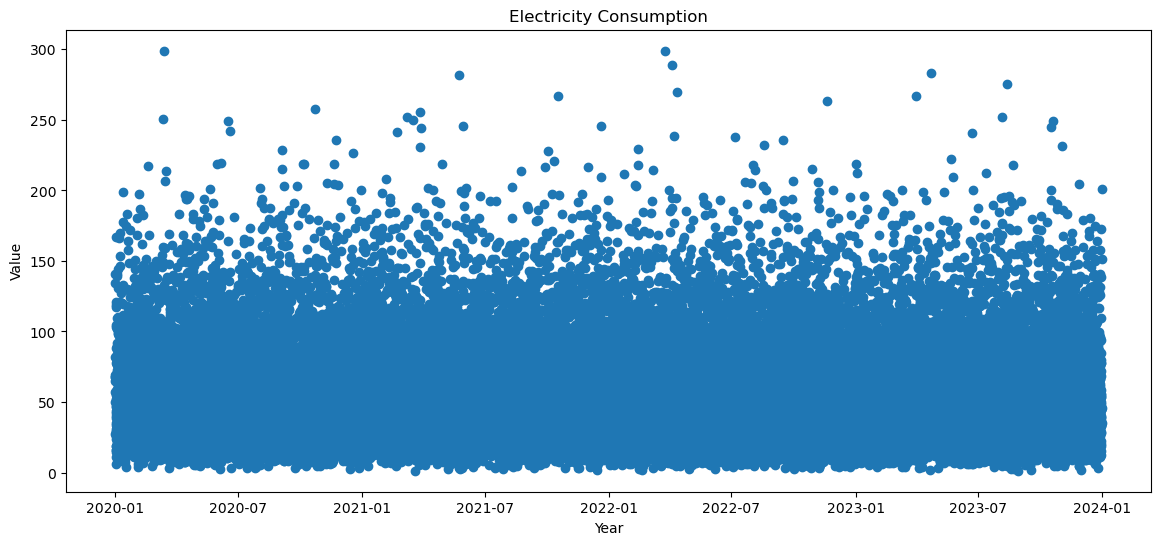

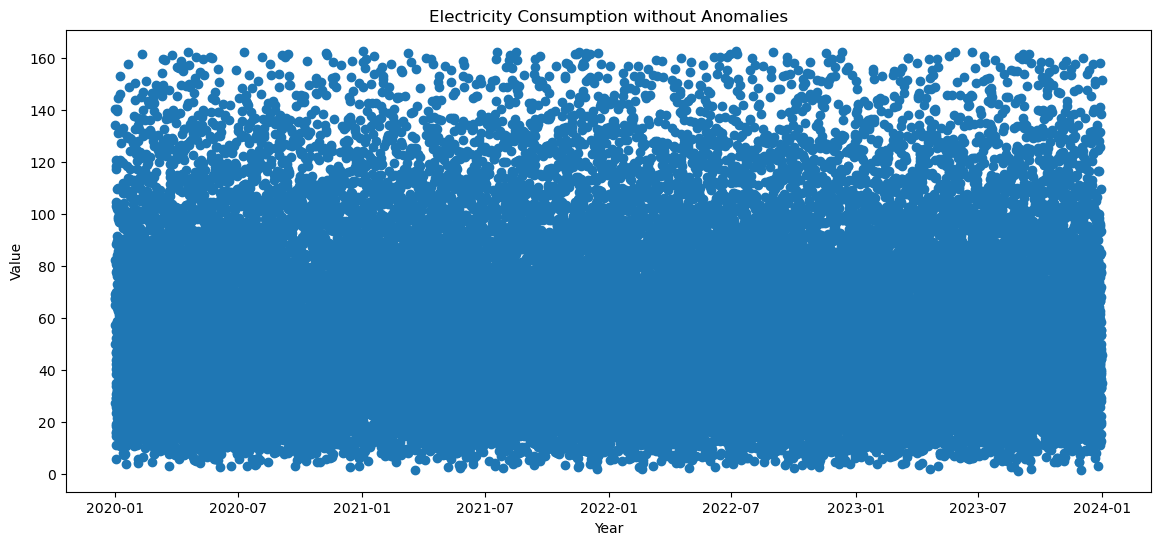

In [23]:
#Create the scatterplot
scatter(electricity_consumption.index,electricity_consumption['Electricity_Consumption'],'Electricity Consumption','Year','Value')
scatter(electricity_consumption_no_anomalies.index,electricity_consumption_no_anomalies['Electricity_Consumption'],'Electricity Consumption without Anomalies','Year','Value')

You can see how the anomalies remove the higher end of the data. The reason why so many data values were removed is because of how deep of a concentration the data lies within the lower values of the data. There is not really going to be a difference when looking at the data without the anomalies compared to with so I am going to include the anomalies in the data.

## 1.2 Exploratory Data Analysis (EDA): 
Visualize the data to understand trends, seasonality, and other characteristics.

Decompose the series to observe its components: trend, seasonality, and residuals.

### Visualise Electricity Consumption Data

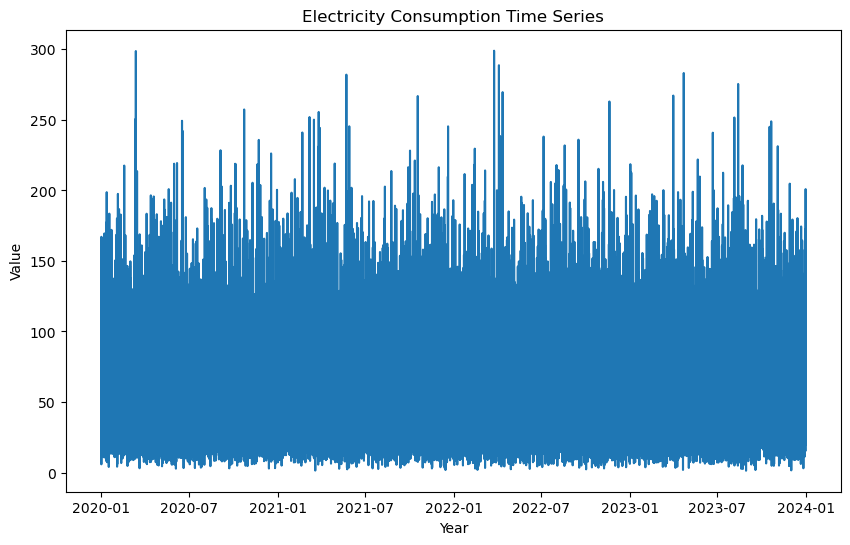

In [24]:
#Create a scatterplot of the data which includes the anomalies
time_series(electricity_consumption.index,electricity_consumption['Electricity_Consumption'],'Electricity Consumption Time Series','Year','Value')

This currently is so concentrated in data with such little fluctuation that it is hard to tell what the data is representing. I am going to aggregate the data so that each value becomes equal to the day that is recorded on rather than the hour.

### Daily aggregation of data

In [25]:
#Create a dataframe which adds the day values based on the month
electricity_consumption_weekly = electricity_consumption.groupby(pd.Grouper(freq='W')).sum()
electricity_consumption_weekly.index = electricity_consumption_weekly.index - pd.offsets.MonthBegin(1)
electricity_consumption_weekly

,Electricity_Consumption,zscore
Date,,
2020-01-01,7217.985847,1.048621
2020-01-01,10074.915005,0.586035
2020-01-01,9053.897644,-29.170024
2020-01-01,9664.950474,-11.361782
2020-02-01,10385.364116,9.633621
...,...,...
2023-12-01,9887.210314,-4.884344
2023-12-01,9163.265487,-25.982658
2023-12-01,10201.935972,4.287876


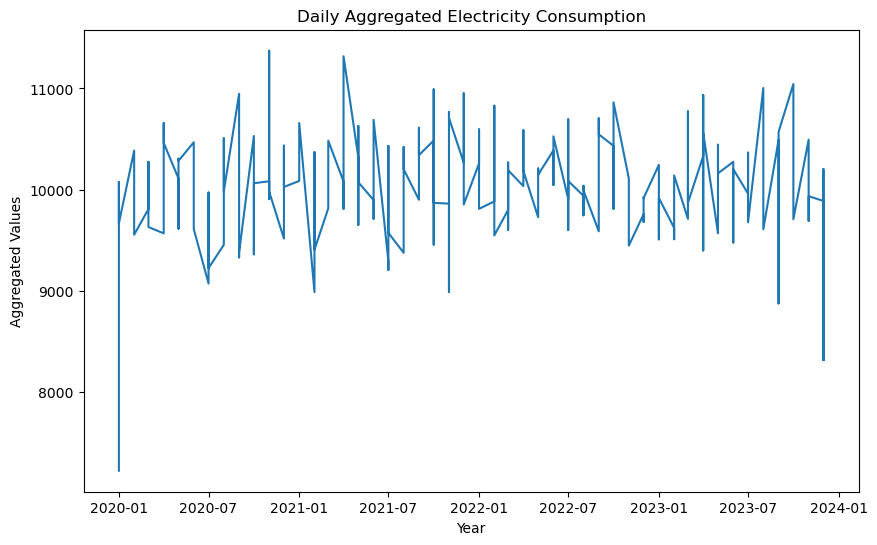

In [26]:
#Create a time series of the data that has been aggregated for the weekly values
time_series(electricity_consumption_weekly.index,electricity_consumption_weekly['Electricity_Consumption'],'Daily Aggregated Electricity Consumption','Year','Aggregated Values')

There is still not a clear story that is being displayed with the data using the daily aggregation. The next step is to look at the data and aggregate it based on the monthly values.

### Monthly aggregation of data

In [27]:
#Create a dataframe which adds the day values based on the month
electricity_consumption_monthly = electricity_consumption.groupby(pd.Grouper(freq='M')).sum()
electricity_consumption_monthly.index = electricity_consumption_monthly.index - pd.offsets.MonthBegin(1)
electricity_consumption_monthly

,Electricity_Consumption,zscore
Date,,
2020-01-01,43220.244757,-38.125102
2020-02-01,41420.117020,-6.863583
2020-03-01,43829.811043,-20.360184
2020-04-01,44042.663165,27.704886
2020-05-01,44269.222617,-7.554175
...,...,...
2023-08-01,44433.830873,-2.756908
2023-09-01,41993.264553,-32.021842
2023-10-01,45771.057975,36.214622


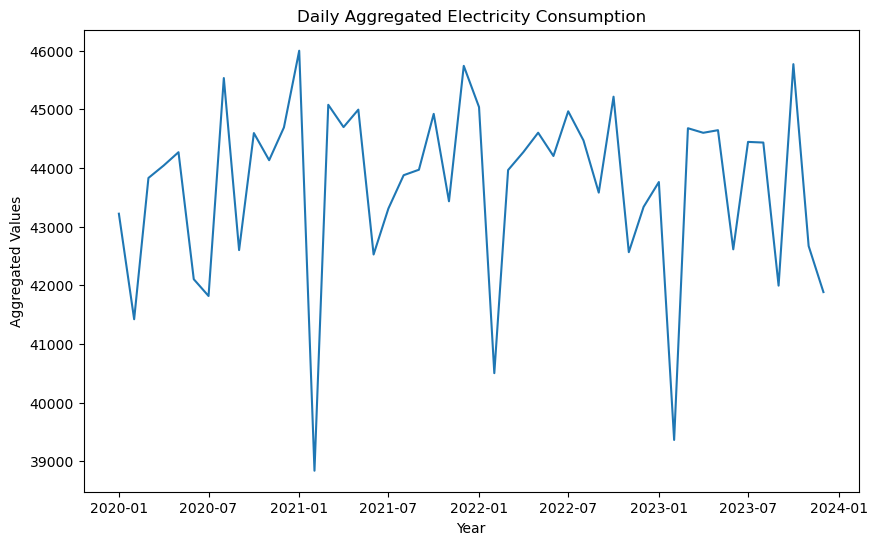

In [28]:
#Create a time series of the data that has been aggregated for the monthly values
time_series(electricity_consumption_monthly.index,electricity_consumption_monthly['Electricity_Consumption'],'Daily Aggregated Electricity Consumption','Year','Aggregated Values')

### Exploration of Seasonal Decomposition of Electricity Consumption

#### Seasonality Period Decision
There is no given seasonality so there are 2 methods that I am going to use to determine the seasonal period
1. Visualisation
2. ACF & PACF Plots

##### 1. Visualisation Review of Seasonality Period Decision

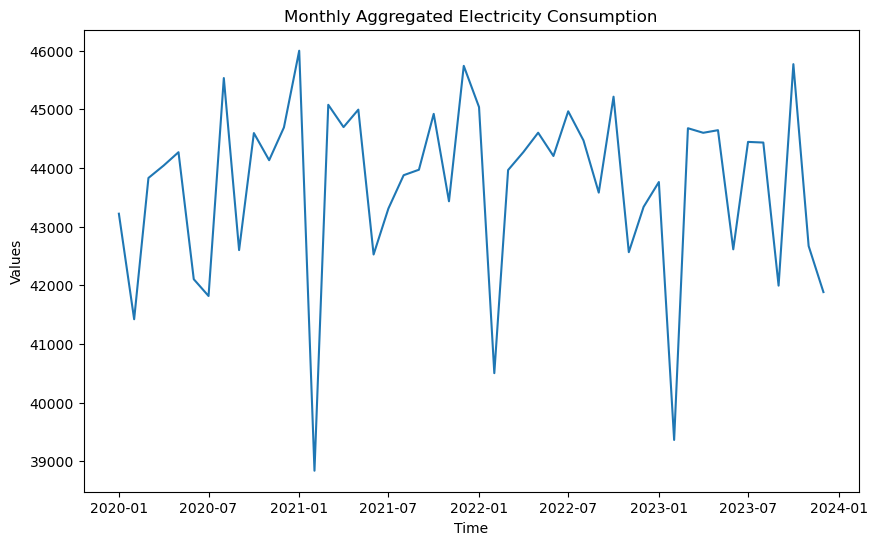

In [29]:
#Create a time series of the data has been aggregated for the month
time_series(electricity_consumption_monthly.index,electricity_consumption_monthly['Electricity_Consumption'],'Monthly Aggregated Electricity Consumption','Time','Values')

With the decrease in the density of data there is a more clear image of how the data moves with time. It still does look quite stationary. The most important step is to try and identify a seasonal period that can be used which will give accurate results. You can observe that the second month of every year has a sharp spike which might suggest a seasonal period of a year

##### 2. ACF & PACF Plots
Looking at the ACF and PACF plots is going to give insight for different things

1. ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

2. PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

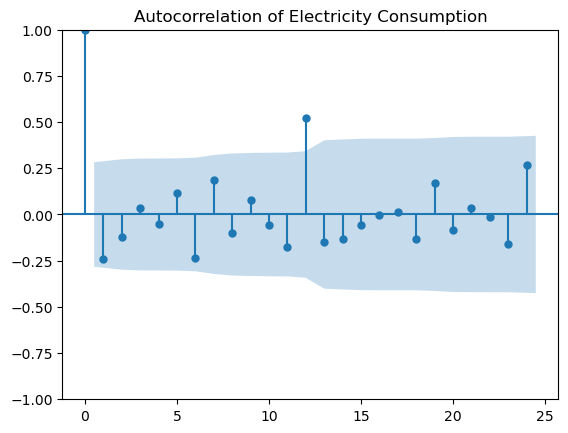

In [30]:
#Plot the electricity consumption ACF plot
electricity_consumption_acf = plot_acf(electricity_consumption_monthly['Electricity_Consumption'],lags=24,title='Autocorrelation of Electricity Consumption')

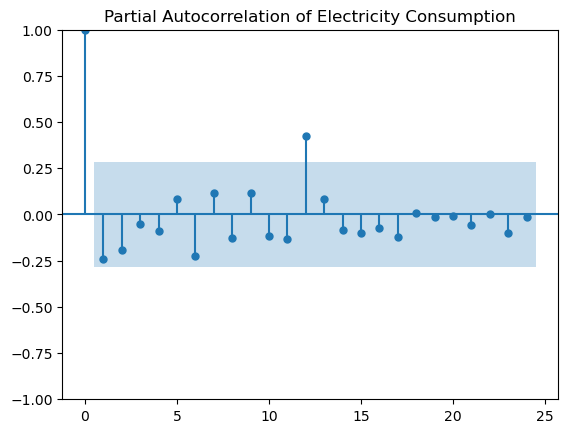

In [31]:
#Plot the electricity consumption PACF plot
electricity_consumption_pacf = plot_pacf(electricity_consumption_monthly['Electricity_Consumption'],lags=24,title='Partial Autocorrelation of Electricity Consumption')

For both the ACF and PACF plot there is a clear value of 12 which suggests that there is a seasonality component. This would mean that over a year seasonal period there is a constant pattern. 

### Seasonal Decomposition of Electricity Consumption
Using a period of a year, break down the data into its individual components using seasonal decomposition

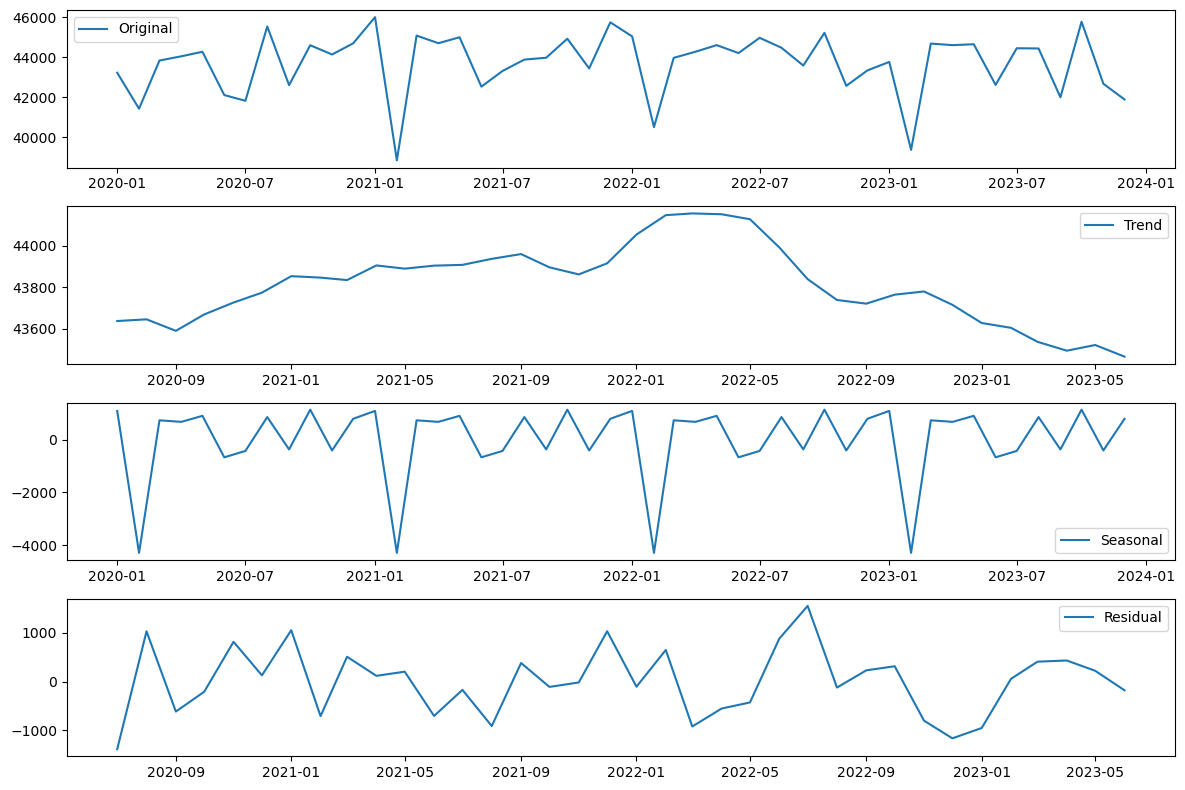

In [32]:
#Create a variable which can be referrenced to get each of the different series
#Plot the decomposition with a period of 1 year
electricity_consumption_decomposition = decompose_seasonality(electricity_consumption_monthly['Electricity_Consumption'],12)
plot_seasonal_decomposition(electricity_consumption_monthly['Electricity_Consumption'],12)

#### Trend of Electricity Consumption
To get an idea of how the data changes over time, showing line of best fit should entail how much of a trend there is.

In [33]:
#Create an incrementing months column so that a line of best fit can go through the data
electricity_consumption_monthly['Incrementing Month'] = range(1,len(electricity_consumption_monthly) + 1)

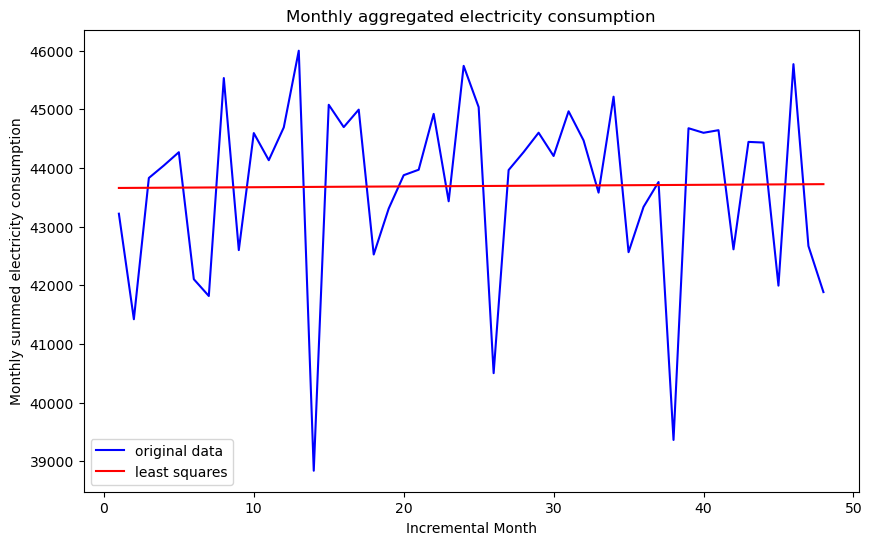

In [34]:
#Plot the original data with the least squares line
plot_least_squares_line(electricity_consumption_monthly['Incrementing Month'],electricity_consumption_monthly['Electricity_Consumption'],'Monthly aggregated electricity consumption','Incremental Month','Monthly summed electricity consumption')

There is no overall trend change in values as time continues. This shows a stationary graph.

#### Seasonality of Electricity Consumption

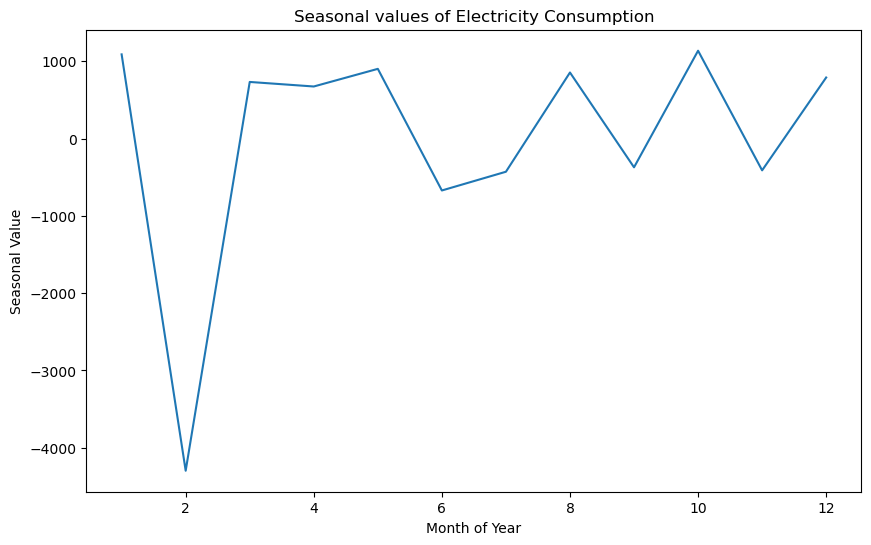

In [35]:
#Create a dataframe for the first year of the seasonality
electricity_consumption_seasonal_values = pd.DataFrame(electricity_consumption_decomposition[2].iloc[0:12])
electricity_consumption_seasonal_values['Incrementing Month'] = range(1, len(electricity_consumption_seasonal_values)+1)
time_series(electricity_consumption_seasonal_values['Incrementing Month'],electricity_consumption_seasonal_values['seasonal'],'Seasonal values of Electricity Consumption','Month of Year','Seasonal Value')

There is a drop in values in February (month 2) of the yearly cycle but after that it oscilates above and below 0. This is suggesting that there might be some consistient factor that takes place in the second month of the year which results in the lower values.

#### Residual of Electricity Consumption

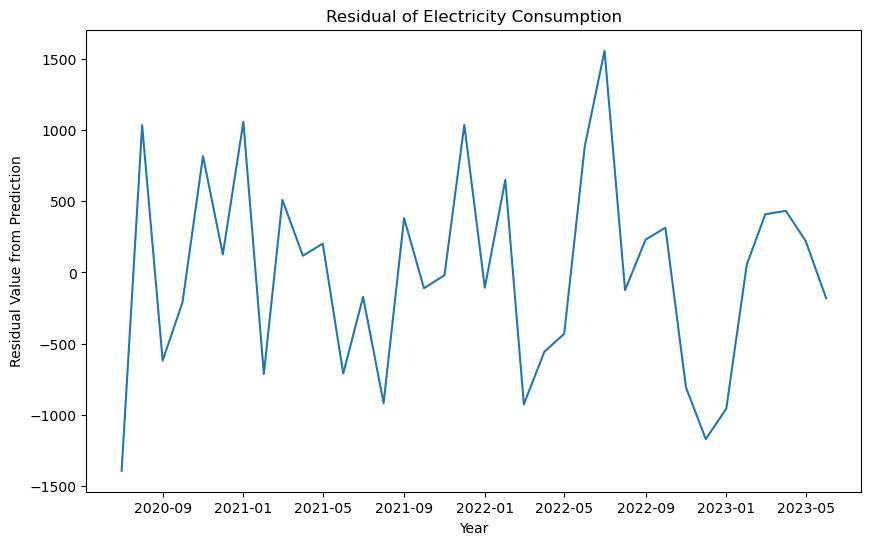

In [36]:
#Plot the residual of websites
time_series(electricity_consumption_decomposition[3].index,electricity_consumption_decomposition[3],'Residual of Electricity Consumption','Year','Residual Value from Prediction')

The pattern is quite inconsistient and oscilates around a mean of 0. Therefore the seasonal decomposition has done a decent job. The residuals go between -1500 and +1500 and considering values lie between 39000 and 47000 this means that the residuals comparatively were very low. This represents a seasonal decomposition.

## 1.3 ARIMA Model Building:

1. Determine the order of differencing (d) needed to make the series stationary.

2. Identify the autoregressive term (p) and moving average term (q) using plots such as the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

3. Construct and fit the ARIMA model to the historical data.

#### ARIMA Modeling
The following ARIMA modeling types are going to be explored
- AR: Autoregressive Model (p value - using PACF to find order)
- MA: Moving Average Model (q value - using ACF to find order)
- ARMA: Autoregressive Moving Average (p value, q value)
- ARIMA: Autoregressive Integrated Moving Average (p value, d value, q value)
- SARIMA: Seasonal Autoregressive Integrated Moving Average (p value, d value, q value, P value, D value, Q value, seasonal). P value found through seasonal PACF, D value found through seasonal ADF statistic, Q value found through seasonal ACF

#### p,d,q values

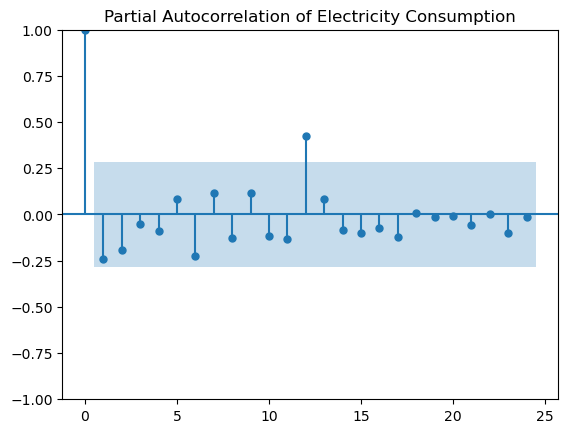

In [37]:
#Use the pacf plot to find the p model
electricity_consumption_pacf

In [38]:
#Create a list of p orders for electricity consumption
p_orders_value = [1,6]

In [39]:
#Look at the ADF statistic to determine the d value
adf_test(electricity_consumption_monthly['Electricity_Consumption'])

ADF Statistic:  -8.513005555290894
P-Value:  1.1538519021462014e-13
Critical Value: 
	1%: -3.58
	5%: -2.93
	10%: -2.60


In [40]:
#d orders for electricity consumption
d_orders_value = [0]

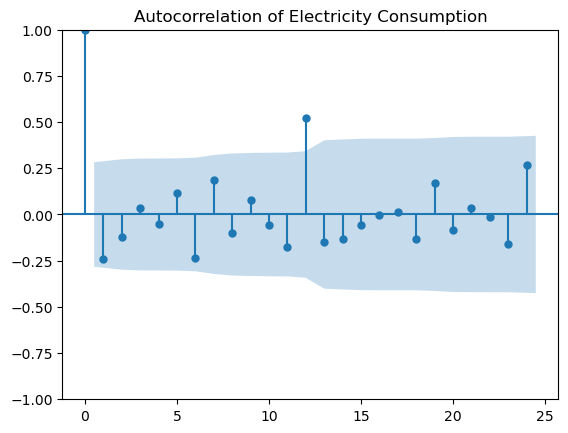

In [41]:
#use the acf plot to find the q model
electricity_consumption_acf

In [42]:
#List the q orders for electricity consumption
q_orders_value = [1,6]

#### P,D,Q Values

In [43]:
#Remove the seasonal values from the monthly aggregated data
electricity_consumption_monthly_seasonally_adjusted = electricity_consumption_decomposition[0] - electricity_consumption_decomposition[2]
electricity_consumption_monthly_seasonally_adjusted

Date
2020-01-01    42130.460090
2020-02-01    45718.521101
2020-03-01    43096.905675
2020-04-01    43368.487217
2020-05-01    43366.794919
                  ...     
2023-08-01    43578.675195
2023-09-01    42365.004067
2023-10-01    44634.014536
2023-11-01    43080.041621
2023-12-01    41092.799446
Length: 48, dtype: float64

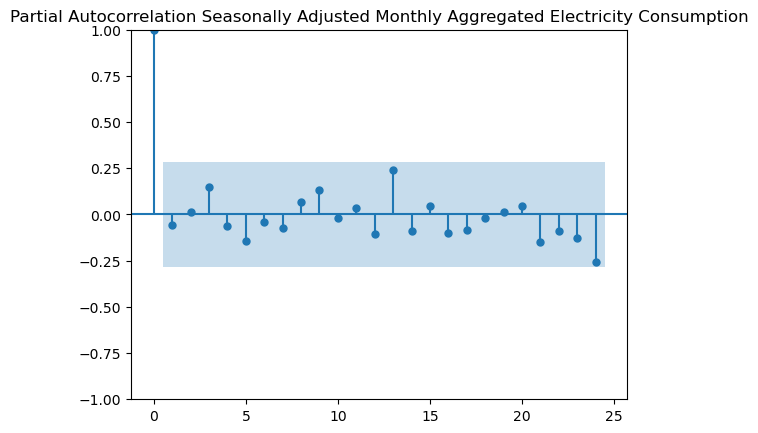

In [44]:
#Use the seasonally adjusted pacf to find P values
electricity_consumption_seasonally_adjusted_pacf = plot_pacf(electricity_consumption_monthly_seasonally_adjusted,title='Partial Autocorrelation Seasonally Adjusted Monthly Aggregated Electricity Consumption', lags=24)

In [45]:
#Create a list of P orders
P_orders_value = [3,5]

In [46]:
#Look at the ADF statistic the seasonally adjusted value to find the D values
adf_test(electricity_consumption_monthly_seasonally_adjusted)

ADF Statistic:  -6.732154846551454
P-Value:  3.275305729372998e-09
Critical Value: 
	1%: -3.58
	5%: -2.93
	10%: -2.60


In [47]:
#Create a list of D orders
D_orders_value = [0]

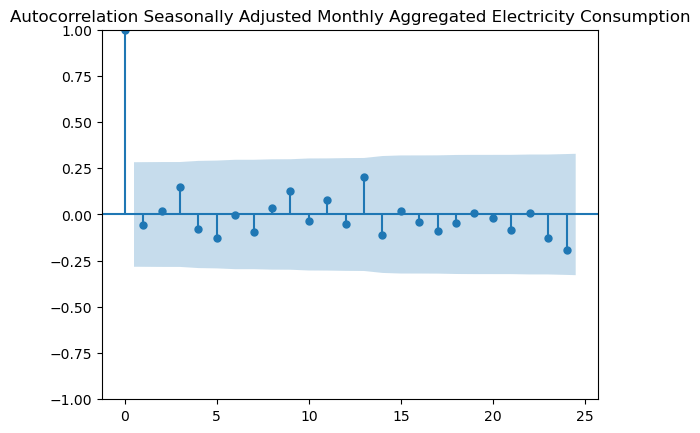

In [48]:
#Use the ACF plot to find Q value
electricity_consumption_seasonally_adjusted_acf = plot_acf(electricity_consumption_monthly_seasonally_adjusted,title='Autocorrelation Seasonally Adjusted Monthly Aggregated Electricity Consumption',lags= 24)

In [49]:
#Create a list of Q orders
Q_orders_value = [3]

#### ARIMA/SARIMA Model Evaluation

In [50]:
#Create a list of different ARIMA models to choose
warnings.filterwarnings("ignore")
evaluate_time_series_models(electricity_consumption_monthly['Electricity_Consumption'],p_orders_value,q_orders_value,d_orders_value)

,Model,Order,AIC,BIC
2,MA,"(0, 0, 1)",842.497007,848.110610
4,ARMA,"(1, 0, 1)",843.587484,851.072288
8,ARIMA,"(1, 0, 1)",843.587484,851.072288
0,AR,"(1, 0, 0)",844.077841,849.691444
1,AR,"(6, 0, 0)",848.217660,863.187268
3,MA,"(0, 0, 6)",848.497862,863.467470
6,ARMA,"(6, 0, 1)",849.169454,866.010263
10,ARIMA,"(6, 0, 1)",849.169454,866.010263
7,ARMA,"(6, 0, 6)",849.764093,875.960907
11,ARIMA,"(6, 0, 6)",849.764093,875.960907


The ARIMA models are good but it is likely that a SARIMA model will be better due to the seasonal patterns that were observed in the data. MA model was at the top which means that the moving average was the most substaintial part of the model without including seasonality.

In [51]:
#Create the SARIMA model outcomes
select_best_sarima_model(electricity_consumption_monthly['Electricity_Consumption'],p_orders_value,d_orders_value,q_orders_value,P_orders_value,D_orders_value,Q_orders_value,12)

{'aic': 828.4812539198051,
 'bic': 837.8372589743445,
 'pdq': (1, 0, 0),
 'seasonal_pdq': (0, 0, 2, 12)}

## 1.4 Model Evaluation:
Use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and others to evaluate the model.

Discuss the model's limitations and any discrepancies observed between the predicted and actual values.

There are 3 different methods of modeling I am going to use.

1. ARIMA Model - Using the orders from the list above forecast the data

2. SARIMA Model - Using the orders from the list above forecast the data and include the seasonal impact

3. Holt Winter's Seasonal Method - Triple exponential smoothing is going to incorporate seasonality into the system

In [52]:
#Get the index value to split the data 0.7 to 0.3 for train and testing respectively.
split_index = int(len(electricity_consumption_monthly)*0.7)

#Apply the index to train and test data
train_data = electricity_consumption_monthly.iloc[:split_index+1]
test_data = electricity_consumption_monthly.iloc[split_index:]

### 1. ARIMA (0,0,1) Modeling

In [53]:
# Fit ARIMA model to the training data
model_arima_1 = ARIMA(train_data['Electricity_Consumption'], order=(0, 0, 1))
model_arima_1 = model_arima_1.fit()

# Make predictions on the test data
test_predictions_arima_1 = model_arima_1.predict(start=test_data.index[1], end=test_data.index[-1], dynamic=False)

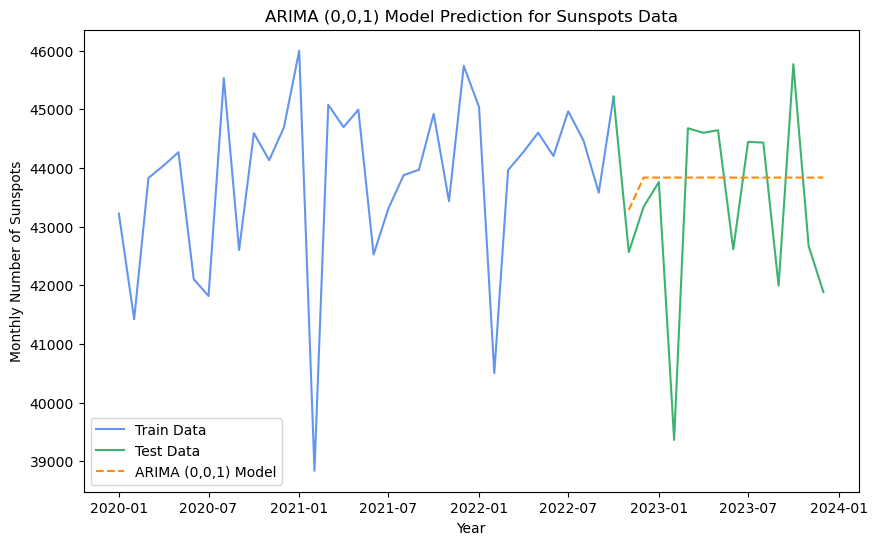

In [54]:

#Plot the arima model next to the original data with the 80/20 data split
test_training_model(train_data['Electricity_Consumption'], test_data['Electricity_Consumption'], test_predictions_arima_1,
                    'Year', 'Monthly Number of Sunspots', 'ARIMA (0,0,1) Model Prediction for Sunspots Data','ARIMA (0,0,1) Model')

The ARIMA model does not take into account autoregressive, differencing and incorporates a moving average of 1 without any seasonality. This is why the graph is a straight line as the moving average of line is close to 0 because it is a stationary graph.

In [55]:
#Get the mean absolute error for arima model
arima_1_mae = mean_absolute_error(test_data['Electricity_Consumption'][0:-1],test_predictions_arima_1)

actual_mean = test_data['Electricity_Consumption'].mean()

arima_1_mae_percentage = (arima_1_mae / actual_mean) * 100

arima_1_mae_percentage

2.965495680661785

In [88]:
#Create a forecast model for the next 5 years for ARIMA (12,1,1)
#This will be modeled in the forecast section
forecast_arima_1 = model_arima_1.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+12, dynamic=False)

### 2. SARIMA Model (1, 0, 0), (0, 0, 2, 12)

In [56]:
#Fit SARIMA model to the training data
model_sarima_1 = SARIMAX(train_data['Electricity_Consumption'], order=(1,0,0), seasonal_order=(0, 0, 2, 12))
model_sarima_1 = model_sarima_1.fit()

# Make predictions on the test data
test_predictions_sarima_1 = model_sarima_1.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30724D+00    |proj g|=  4.65669D-01

At iterate    5    f=  9.19330D+00    |proj g|=  3.45177D-02

At iterate   10    f=  9.19220D+00    |proj g|=  1.71669D-03

At iterate   15    f=  9.19125D+00    |proj g|=  3.06383D-02

At iterate   20    f=  9.14236D+00    |proj g|=  6.49230D-03

At iterate   25    f=  9.14222D+00    |proj g|=  2.67285D-04

At iterate   30    f=  9.14198D+00    |proj g|=  6.53613D-03

At iterate   35    f=  9.10708D+00    |proj g|=  1.07253D-01

At iterate   40    f=  9.09218D+00    |proj g|=  1.13050D-02

At iterate   45    f=  9.09105D+00    |proj g|=  3.80102D-03

At iterate   50    f=  9.09011D+00    |proj g|=  1.15459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

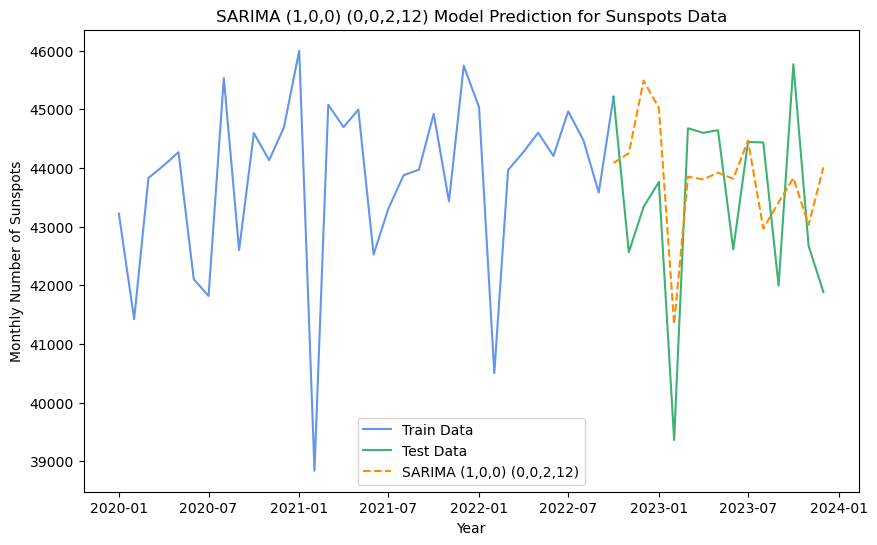

In [57]:
#Plot the arima model next to the original data with the 80/20 data split
test_training_model(train_data['Electricity_Consumption'], test_data['Electricity_Consumption'], test_predictions_sarima_1,
                    'Year', 'Monthly Number of Sunspots', 'SARIMA (1,0,0) (0,0,2,12) Model Prediction for Sunspots Data','SARIMA (1,0,0) (0,0,2,12)')

In [59]:
#Get the mean absolute error for sarima model
sarima_1_mae = mean_absolute_error(test_data['Electricity_Consumption'],test_predictions_sarima_1)

actual_mean = test_data['Electricity_Consumption'].mean()

sarima_1_mae_percentage = (sarima_1_mae / actual_mean) * 100

sarima_1_mae_percentage

2.929138823372951

In [89]:
#Forecast the model based off of the training data
forecast_sarima = model_sarima_1.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+12, dynamic=False)

### 3. Holt Winter's Seasonal Method
This is commonly known as triple exponential smoothing and is used when the data exhibits seasonality. It incorporates SES, trend and seasonality which is why it is triple exponential smoothing.

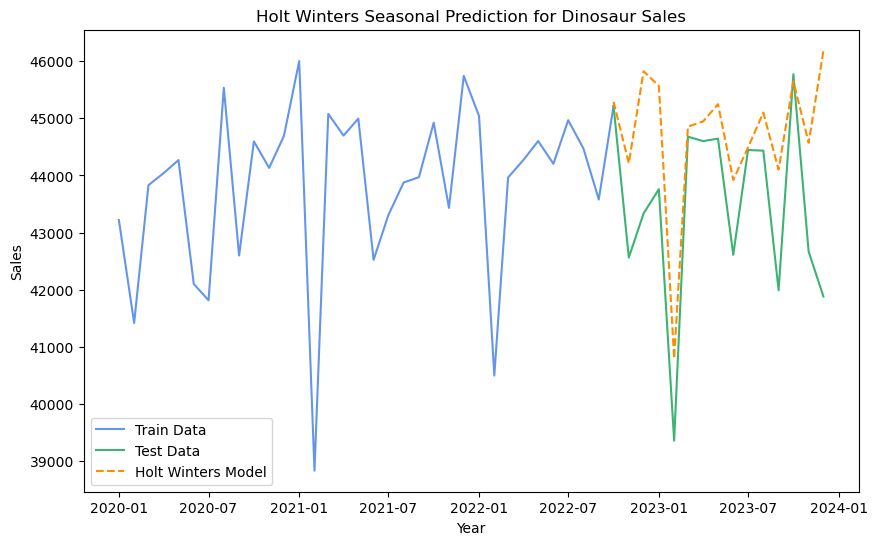

In [80]:

# Fit Holt-Winters method to the training data with multiplicative seasonality
holt_winters_1_model = ExponentialSmoothing(train_data['Electricity_Consumption'], seasonal_periods=12, trend='add', seasonal='add')
holt_winters_1_model = holt_winters_1_model.fit(smoothing_level=0, smoothing_trend=1, smoothing_seasonal=0.5)

# Make predictions on the test data
holt_winters_test_predictions = holt_winters_1_model.predict(start=test_data.index[0], end=test_data.index[-1])

test_training_model(train_data['Electricity_Consumption'], test_data['Electricity_Consumption'], holt_winters_test_predictions,
                    'Year', 'Sales', 'Holt Winters Seasonal Prediction for Dinosaur Sales', 'Holt Winters Model')

In [81]:
#Get the mean absolute error for Holt Winter's Seasonal Method
holt_winters_mae = mean_absolute_error(test_data['Electricity_Consumption'],holt_winters_test_predictions)

actual_mean = test_data['Electricity_Consumption'].mean()

holt_winters_mae_percentage = (holt_winters_mae / actual_mean) * 100

holt_winters_mae_percentage

2.9183637270689826

In [90]:

# Make predictions based on the test data
forecast_holt_winters = holt_winters_1_model.predict(start=test_data['Incrementing Month'][-1], end=test_data['Incrementing Month'][-1]+12)

In [83]:
print(f'mae ARIMA (0,0,1): {arima_1_mae_percentage}')
print(f'mae SARIMA (1,0,0) (0,0,2,12): {sarima_1_mae_percentage}')
print(f'mae Holt Winters: {holt_winters_mae_percentage}')

mae ARIMA (0,,1): 2.965495680661785
mae SARIMA (1,0,0) (0,0,2,12): 2.929138823372951
mae Holt Winters: 2.9183637270689826


The mean absolute error values are very close. I think that due to the smaller test sample the outcomes are similar.

## 1.5 Forecasting
Forecast the next 5 years of data for all models as they had similar percentage values

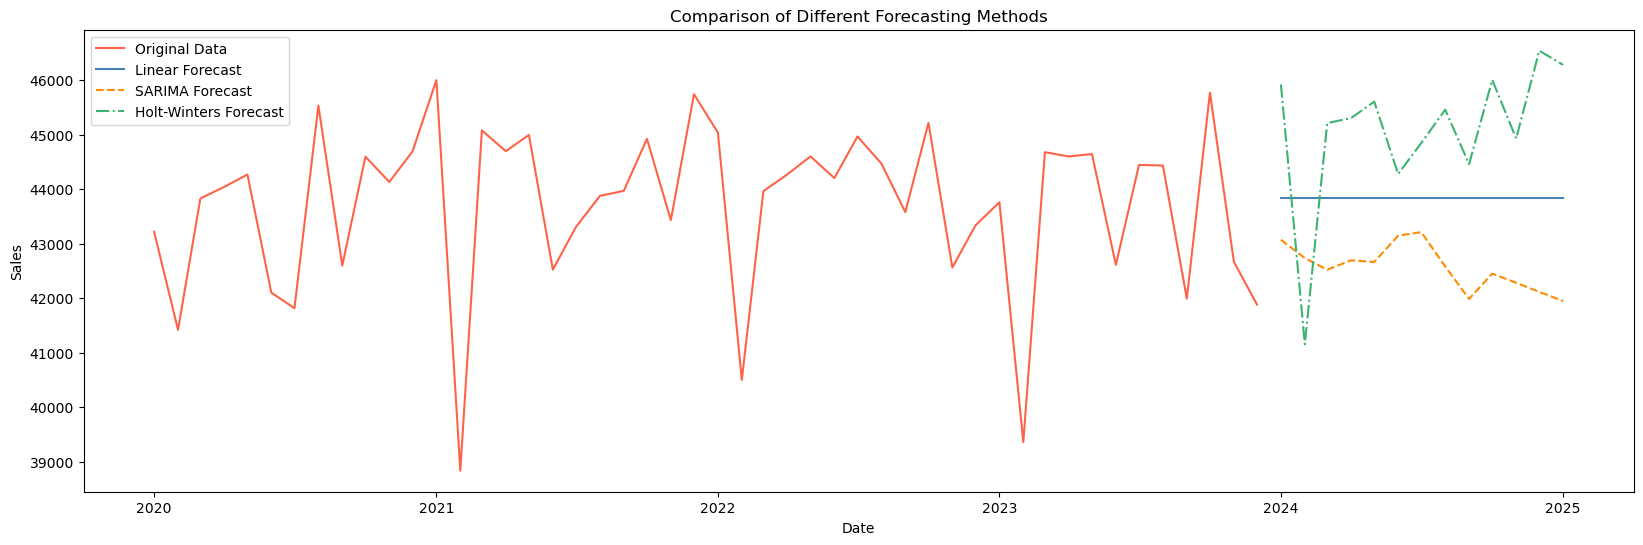

In [95]:
#Use the 3 prediction models to forecast the next year (12 values)
#Plot the original data
plt.figure(figsize=(20, 6))
plt.plot(electricity_consumption_monthly.index, electricity_consumption_monthly['Electricity_Consumption'], color='tomato', label='Original Data')

# Plot the forecasts with different colors and line styles
plt.plot(forecast_arima_1, linestyle='-', color='steelblue', label='Linear Forecast')
plt.plot(forecast_sarima, linestyle='--', color='darkorange', label='SARIMA Forecast')
plt.plot(forecast_holt_winters, linestyle='-.', color='mediumseagreen', label='Holt-Winters Forecast')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Different Forecasting Methods')

# Add legend
plt.legend()

# Show plot
plt.show()

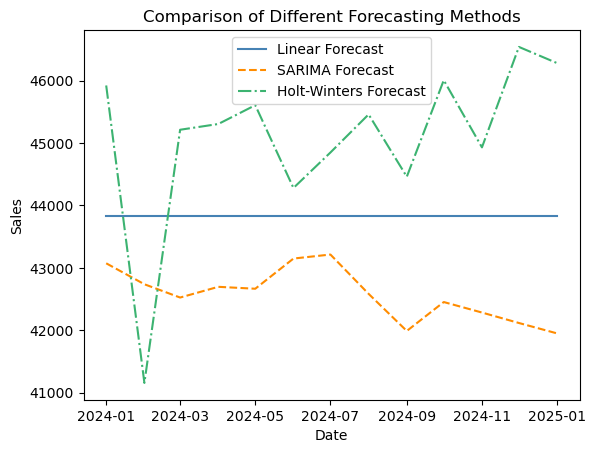

In [96]:
# Plot the forecasts with different colors and line styles
plt.plot(forecast_arima_1, linestyle='-', color='steelblue', label='Linear Forecast')
plt.plot(forecast_sarima, linestyle='--', color='darkorange', label='SARIMA Forecast')
plt.plot(forecast_holt_winters, linestyle='-.', color='mediumseagreen', label='Holt-Winters Forecast')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Different Forecasting Methods')

# Add legend
plt.legend()

# Show plot
plt.show()